In [1]:
# Install dependencies if needed
!pip install pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

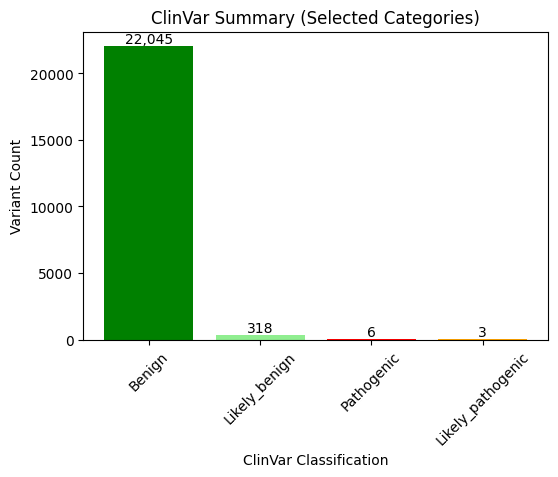

In [33]:
# --- Step 1: Load the CSV ---
import pandas as pd
import matplotlib.pyplot as plt

# Load your file
df = pd.read_csv("/content/output_annotation.csv")

# --- Step 2: Define the categories we care about ---
target_categories = ["Benign", "Likely_benign", "Pathogenic", "Likely_pathogenic"]

# --- Step 3: Normalize the CLNSIG column ---
# Convert to lowercase for matching
df['CLNSIG_clean'] = df['CLNSIG'].astype(str).str.strip().str.lower()

# Map to target categories if they match
mapping = {
    "benign": "Benign",
    "likely_benign": "Likely_benign",
    "pathogenic": "Pathogenic",
    "likely_pathogenic": "Likely_pathogenic"
}

df['CLNSIG_mapped'] = df['CLNSIG_clean'].map(mapping)

# --- Step 4: Filter only the rows we care about ---
filtered_df = df[df['CLNSIG_mapped'].isin(mapping.values())]

# --- Step 5: Count and plot ---
clinvar_counts = filtered_df['CLNSIG_mapped'].value_counts()

plt.figure(figsize=(6, 4))
bars = plt.bar(clinvar_counts.index, clinvar_counts.values, color=["green", "lightgreen", "red", "orange"])
plt.xlabel("ClinVar Classification")
plt.ylabel("Variant Count")
plt.title("ClinVar Summary (Selected Categories)")
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", ha='center', va='bottom')
# Save the figure before showing
plt.savefig('ClinVar Summary.png', dpi=300, bbox_inches='tight')
plt.show()





Exonic Variant Function Counts (Standard Labels):
ExonicFunc.refGene
Synonymous                 11508
Missense                   10826
In-frame substitution        256
Unknown                      193
Nonsense                     135
Frameshift substitution       96
startloss                     23
Stop-loss                     18
Name: count, dtype: int64


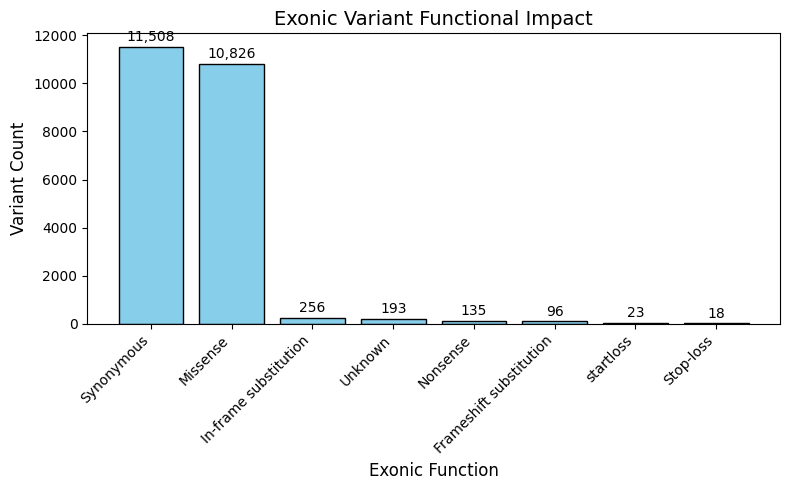

In [37]:
import matplotlib.pyplot as plt

if 'Func.refGene' in df.columns and 'ExonicFunc.refGene' in df.columns:
    # Filter only exonic variants
    exonic_df = df[df['Func.refGene'] == 'exonic'].copy()

    # Mapping from raw ANNOVAR labels to standard terminology
    label_map = {
        "nonsynonymous SNV": "Missense",
        "stopgain": "Nonsense",
        "synonymous SNV": "Synonymous",
        "stoploss": "Stop-loss",
        "frameshift insertion": "Frameshift insertion",
        "frameshift deletion": "Frameshift deletion",
        "frameshift substitution": "Frameshift substitution",
        "nonframeshift insertion": "In-frame insertion",
        "nonframeshift deletion": "In-frame deletion",
        "nonframeshift substitution": "In-frame substitution",
        "unknown": "Unknown",
    }

    # Apply mapping
    exonic_df['ExonicFunc.refGene'] = exonic_df['ExonicFunc.refGene'].replace(label_map)

    # Count functional impact types
    func_counts = exonic_df['ExonicFunc.refGene'].value_counts(dropna=False)

    print("\nExonic Variant Function Counts (Standard Labels):")
    print(func_counts)

    # --- Bar chart ---
    plt.figure(figsize=(8, 5))
    bars = plt.bar(func_counts.index, func_counts.values, color="skyblue", edgecolor="black")
    plt.xlabel("Exonic Function", fontsize=12)
    plt.ylabel("Variant Count", fontsize=12)
    plt.title("Exonic Variant Functional Impact", fontsize=14)
    plt.xticks(rotation=45, ha="right")

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(func_counts.values) * 0.01,
            f"{int(height):,}",
            ha="center",
            va="bottom",
            fontsize=10
        )

    plt.tight_layout()

    # Save the figure before showing
    plt.savefig('exonic_variant_functional_impact.png', dpi=300, bbox_inches='tight')

    plt.show()

else:
    print("⚠️ Missing columns for exonic function breakdown.")


In [14]:
#3. Rare Pathogenic Hits (Pathogenic/Likely Pathogenic + gnomAD AF < 1%)
# ----------------------------
rare_pathogenic_df = pd.DataFrame()
if 'CLNSIG' in df.columns:
    pathogenic_terms = ['Pathogenic', 'Likely_pathogenic', 'Pathogenic/Likely_pathogenic']
    rare_pathogenic_df = df[
        df['CLNSIG'].str.contains('|'.join(pathogenic_terms), case=False, na=False)
    ]

    # Filter for gnomAD AF if available
    af_cols = [col for col in df.columns if 'gnomAD' in col and 'AF' in col]
    if af_cols:
        af_col = af_cols[0]
        rare_pathogenic_df = rare_pathogenic_df[pd.to_numeric(rare_pathogenic_df[af_col], errors='coerce') < 0.01]
        print(f"\nRare Pathogenic Variants (AF < 1% using {af_col}): {len(rare_pathogenic_df)}")
    else:
        print("\n⚠️ No gnomAD AF column found. Using ClinVar pathogenic only.")

    # Show table
    display(rare_pathogenic_df.head(10))
else:
    print("⚠️ No 'CLNSIG' column found for pathogenic filtering.")


⚠️ No gnomAD AF column found. Using ClinVar pathogenic only.


,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,AF_nfe,AF_fin,AF_asj,AF_oth,non_topmed_AF_popmax,non_neuro_AF_popmax,non_cancer_AF_popmax,controls_AF_popmax,CLNSIG_clean,CLNSIG_mapped
128,chr1,976215,976215,A,G,exonic,PERM1,.,nonsynonymous SNV,"PERM1:NM_001369898:exon3:c.T2264C:p.V755A,PERM...",...,0.7957,0.8163,0.7621,0.7855,0.9520,0.9532,.,0.9520,pathogenic,Pathogenic
4051,chr1,11794419,11794419,T,G,exonic,MTHFR,.,nonsynonymous SNV,"MTHFR:NM_001330358:exon8:c.A1409C:p.E470A,MTHF...",...,0.3074,0.3094,0.2724,0.2934,0.3102,0.3068,.,0.3110,conflicting_interpretations_of_pathogenicity|o...,NaN
6774,chr1,18872954,18872954,G,T,exonic,ALDH4A1,.,nonsynonymous SNV,"ALDH4A1:NM_001319218:exon14:c.C1430A:p.T477N,A...",...,0.0305,0.0351,0.0103,0.0340,0.0326,0.0308,.,0.0395,conflicting_interpretations_of_pathogenicity,NaN
15929,chr1,55057360,55057360,A,G,exonic,PCSK9,.,synonymous SNV,PCSK9:NM_174936:exon7:c.A1026G:p.Q342Q,...,1,1,1,0.9982,1,1,.,1,conflicting_interpretations_of_pathogenicity,NaN
30179,chr1,160282943,160282943,C,T,splicing,PEX19,"NM_002857:exon3:c.346+1G>A,NM_001193644:exon3:...",.,.,...,.,.,.,.,.,.,.,.,likely_pathogenic,Likely_pathogenic
30869,chr1,162770331,162770331,G,A,exonic,DDR2,.,nonsynonymous SNV,"DDR2:NM_001354982:exon12:c.G1323A:p.M441I,DDR2...",...,0.0196,0.0164,0.0241,0.0212,0.0201,0.0192,.,0.0183,conflicting_interpretations_of_pathogenicity,NaN
32200,chr1,169529737,169529737,T,C,exonic,F5,.,nonsynonymous SNV,F5:NM_000130:exon16:c.A5290G:p.M1764V,...,0.3366,0.2982,0.2552,0.3361,0.4752,0.4457,.,0.4431,conflicting_interpretations_of_pathogenicity,NaN
32213,chr1,169542517,169542517,T,C,exonic,F5,.,nonsynonymous SNV,F5:NM_000130:exon13:c.A2573G:p.K858R,...,0.2613,0.2143,0.1966,0.2569,0.3988,0.3538,.,0.3415,conflicting_interpretations_of_pathogenicity,NaN
33897,chr1,179889309,179889309,G,A,splicing,TOR1AIP1,NM_001267578:exon3:c.554-1G>A,.,.,...,0.6063,0.5597,0.6793,0.5967,0.7519,0.75,.,0.7423,conflicting_interpretations_of_pathogenicity,NaN
36037,chr1,196690107,196690107,C,T,exonic,CFH,.,nonsynonymous SNV,"CFH:NM_000186:exon9:c.C1204T:p.H402Y,CFH:NM_00...",...,0.6162,0.5454,0.6655,0.6292,0.9570,0.9574,.,0.9581,conflicting_interpretations_of_pathogenicity,NaN



Top Genes with Rare Pathogenic Variants:
Gene.refGene
ABCC8    10
WFS1      3
HNF1A     3
FKTN      3
VWF       3
F5        2
PCARE     2
CFH       2
ITPKB     2
PEX19     1
Name: count, dtype: int64


/tmp/ipython-input-2344105358.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genes.values, y=top_genes.index, palette='viridis')


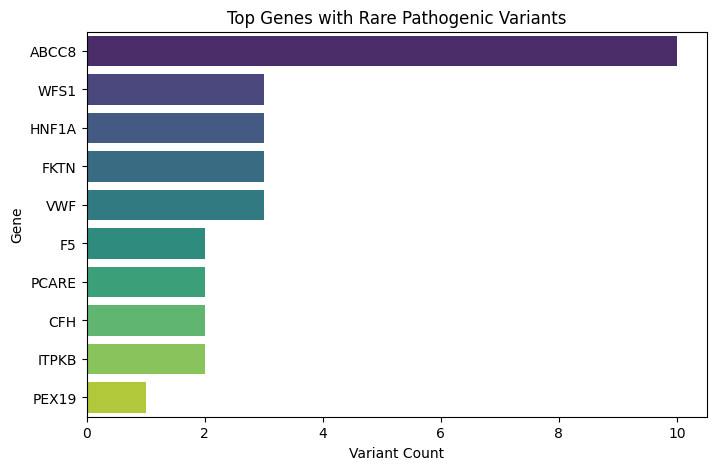

In [38]:
# 4. Top Genes with Rare Pathogenic Variants
# ----------------------------
if not rare_pathogenic_df.empty and 'Gene.refGene' in rare_pathogenic_df.columns:
    top_genes = rare_pathogenic_df['Gene.refGene'].value_counts().head(10)

    print("\nTop Genes with Rare Pathogenic Variants:")
    print(top_genes)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_genes.values, y=top_genes.index, palette='viridis')
    plt.xlabel('Variant Count')
    plt.ylabel('Gene')
    plt.title('Top Genes with Rare Pathogenic Variants')
    # Save the figure before showing
    plt.savefig('Top Genes with Rare Pathogenic Variants.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No rare pathogenic data or 'Gene.refGene' column found.")


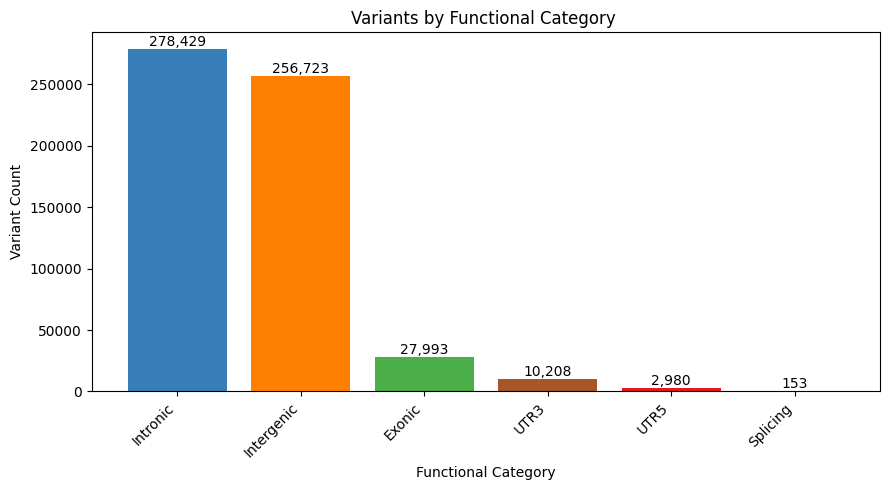

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your file
df = pd.read_csv("/content/output_annotation.csv")

# Drop NA in Func.refGene
df_clean_func = df.dropna(subset=['Func.refGene'])

# Simplify Func.refGene into biologically meaningful categories
def simplify_func_category(val):
    if pd.isna(val):
        return None
    val = val.strip().lower()
    if 'exonic' in val:
        return 'Exonic'
    elif 'splicing' in val:
        return 'Splicing'
    elif 'utr5' in val:
        return 'UTR5'
    elif 'utr3' in val:
        return 'UTR3'
    elif 'intronic' in val:
        return 'Intronic'
    elif 'intergenic' in val:
        return 'Intergenic'
    else:
        return None  # or 'Other' if you want to group rare types

# Apply the simplification
df_clean_func['Func_Simplified'] = df_clean_func['Func.refGene'].apply(simplify_func_category)

# Filter only the rows with relevant (non-None) categories
df_major = df_clean_func[df_clean_func['Func_Simplified'].notna()]

# Count and sort by count descending
func_counts = df_major['Func_Simplified'].value_counts().sort_values(ascending=False)

# Define a color palette (consistent & visually appealing)
color_map = {
    'Exonic': '#4daf4a',       # green
    'Splicing': '#984ea3',     # purple
    'Intronic': '#377eb8',     # blue
    'Intergenic': '#ff7f00',   # orange
    'UTR5': '#e41a1c',         # red
    'UTR3': '#a65628'          # brown
}
colors = [color_map.get(cat, 'gray') for cat in func_counts.index]

# Plot
plt.figure(figsize=(9, 5))
bars = plt.bar(func_counts.index, func_counts.values, color=colors)
plt.xlabel("Functional Category")
plt.ylabel("Variant Count")
plt.title("Variants by Functional Category ")
plt.xticks(rotation=45, ha='right')

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", ha='center', va='bottom')

plt.tight_layout()
# Save the figure before showing
plt.savefig('Variants By Functional Category.png', dpi=300, bbox_inches='tight')
plt.show()


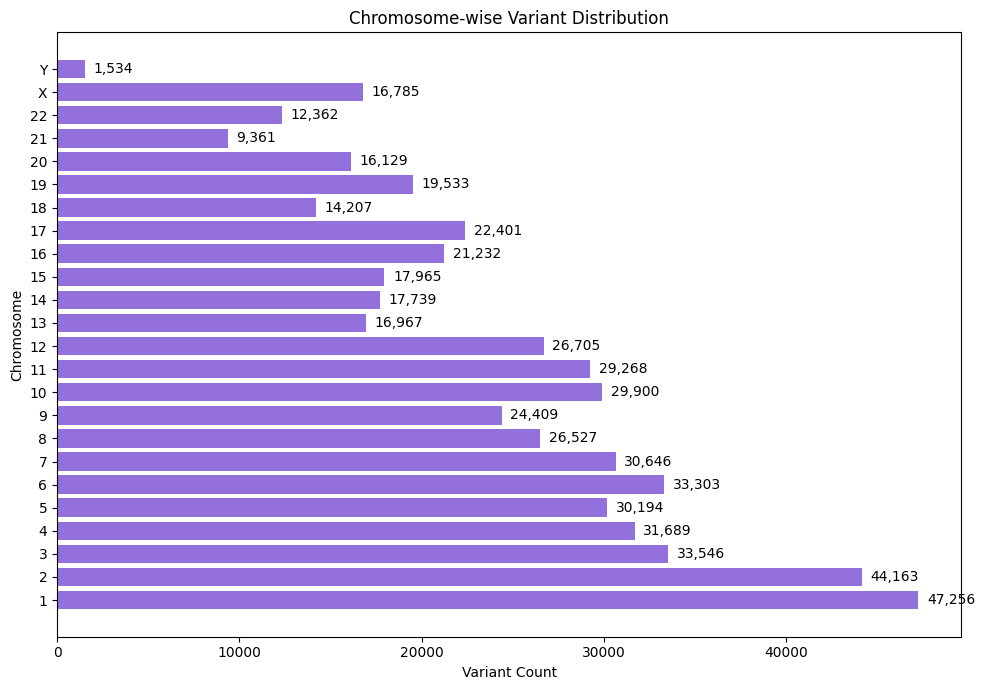

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'Chr' with your actual chromosome column name if different
chrom_col = 'Chr'

# Drop NA chromosome values
df_chrom = df.dropna(subset=[chrom_col])

# Normalize chromosome labels (remove 'chr' prefix if present and capitalize)
df_chrom[chrom_col] = df_chrom[chrom_col].astype(str).str.replace('chr', '', case=False).str.upper()

# Define base chromosome order (autosomes + sex chromosomes)
chrom_order = [str(i) for i in range(1, 23)] + ['X', 'Y']

# Check if 'MT' is present in the data and add it to the order if yes
if 'MT' in df_chrom[chrom_col].unique():
    chrom_order.append('MT')

# Filter chromosomes to known set (some datasets have weird names)
df_chrom = df_chrom[df_chrom[chrom_col].isin(chrom_order)]

# Count variants per chromosome
chrom_counts = df_chrom[chrom_col].value_counts().reindex(chrom_order, fill_value=0)

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
bars = plt.barh(chrom_counts.index, chrom_counts.values, color='mediumpurple')

plt.ylabel("Chromosome")
plt.xlabel("Variant Count")
plt.title("Chromosome-wise Variant Distribution")

# Add numbers at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(chrom_counts.values)*0.01, bar.get_y() + bar.get_height()/2, f"{width:,}", va='center')

plt.tight_layout()

# Save the figure before showing
plt.savefig('chromosome_variant_distribution.png', dpi=300, bbox_inches='tight')

plt.show()
